# Model Training & Evaluation

**Purpose:**
Train and evaluate machine learning models using the **preprocessed and scaled** dataset.

**Steps:**
1.  **Load Data:** Read `df_baseline_processed.csv` and `df_longitudinal_processed.csv`.
2.  **Baseline Model:** Train XGBoost for HC vs MCI.
3.  **Model Benchmarking:** Compare SVM, XGBoost, RF, LR for longitudinal prognosis.
4.  **Longitudinal Model:** Train the best model (SVM) and evaluate.
5.  **XAI:** Visualize Feature Importance and Decision Boundary.
6.  **Comparison:** Plot Expected vs Actual Accuracy.

In [11]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pandas.plotting import parallel_coordinates
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA

# Plot settings
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', None)

# Paths
PROCESSED_PATH = "data/processed/"
OUT_FIGS = "report/figs/"
os.makedirs(OUT_FIGS, exist_ok=True)

BASELINE_FILE = "df_baseline_processed.csv"
LONGITUDINAL_FILE = "df_longitudinal_processed.csv"

# Helper for figure save and show
def save_and_show(fig, out_fp):
    """Save matplotlib figure with tight layout and show it."""
    fig.tight_layout()
    fig.savefig(out_fp, bbox_inches='tight', dpi=300)
    plt.show()

# Load Data
print("Loading Processed Data...")
df_baseline = pd.read_csv(os.path.join(PROCESSED_PATH, BASELINE_FILE))
df_longitudinal = pd.read_csv(os.path.join(PROCESSED_PATH, LONGITUDINAL_FILE))

print(f"Baseline Shape: {df_baseline.shape}")
print(f"Longitudinal Shape: {df_longitudinal.shape}")

Loading Processed Data...
Baseline Shape: (82, 572)
Longitudinal Shape: (47, 1799)


# 1. Model Selection Benchmark for Baseline Model

Comparing algorithms (LR, RF, DT, SVM, NB, XGBoost) with feature selection (k=10) using cross-validation.

Available columns in Baseline: ['CVT_LPP_C3', 'CVT_LPP_C4', 'CVT_LPP_Cz', 'CVT_LPP_F3', 'CVT_LPP_F4', 'CVT_LPP_F7', 'CVT_LPP_F8', 'CVT_LPP_Fp1', 'CVT_LPP_Fp2', 'CVT_LPP_Fz', 'CVT_LPP_O1', 'CVT_LPP_O2', 'CVT_LPP_P3', 'CVT_LPP_P4', 'CVT_LPP_POz', 'CVT_LPP_Pz', 'CVT_LPP_T3', 'CVT_LPP_T4', 'CVT_LPP_T5', 'CVT_LPP_T6', 'CVT_LPPmaxLoc_C3', 'CVT_LPPmaxLoc_C4', 'CVT_LPPmaxLoc_Cz', 'CVT_LPPmaxLoc_F3', 'CVT_LPPmaxLoc_F4', 'CVT_LPPmaxLoc_F7', 'CVT_LPPmaxLoc_F8', 'CVT_LPPmaxLoc_Fp1', 'CVT_LPPmaxLoc_Fp2', 'CVT_LPPmaxLoc_Fz', 'CVT_LPPmaxLoc_O1', 'CVT_LPPmaxLoc_O2', 'CVT_LPPmaxLoc_P3', 'CVT_LPPmaxLoc_P4', 'CVT_LPPmaxLoc_POz', 'CVT_LPPmaxLoc_Pz', 'CVT_LPPmaxLoc_T3', 'CVT_LPPmaxLoc_T4', 'CVT_LPPmaxLoc_T5', 'CVT_LPPmaxLoc_T6', 'CVT_N1minLoc_C3', 'CVT_N1minLoc_C4', 'CVT_N1minLoc_Cz', 'CVT_N1minLoc_F3', 'CVT_N1minLoc_F4', 'CVT_N1minLoc_F7', 'CVT_N1minLoc_F8', 'CVT_N1minLoc_Fp1', 'CVT_N1minLoc_Fp2', 'CVT_N1minLoc_Fz', 'CVT_N1minLoc_O1', 'CVT_N1minLoc_O2', 'CVT_N1minLoc_P3', 'CVT_N1minLoc_P4', 'CVT_N1minLoc_

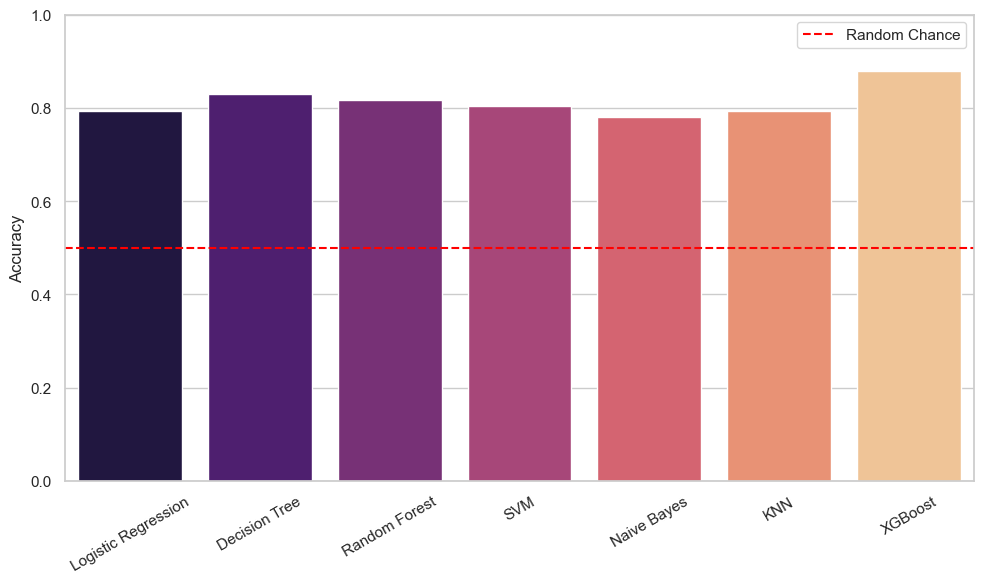

In [12]:
# Baseline Benchmark – Classic ML Models + XGBoost

print(f'Available columns in Baseline: {df_baseline.columns.tolist()}')
target_col = 'Diagnosis_base'
if target_col not in df_baseline.columns:
    target_col = 'Diagnosis'

# Drop clear leakage columns
X_base = df_baseline.drop(columns=[target_col, 'Condition', 'Condition_clean'], errors='ignore')
y_base = df_baseline[target_col]


# Identify and discard columns with variance 0 (all values ​​are the same)
# Capture feature names before VarianceThreshold
feature_names = X_base.columns
selector = VarianceThreshold(threshold=0) 
X_base = selector.fit_transform(X_base)
feature_names = feature_names[selector.get_support()]


# Model List (for benchmark testing)
models_baseline = {
    'Logistic Regression': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
    ]),

    'Decision Tree': Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42))
    ]),

    'Random Forest': Pipeline([
        ('clf', RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42))
    ]),

    'SVM': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', SVC(kernel='linear', class_weight='balanced', random_state=42))
    ]),

    'Naive Bayes': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', GaussianNB())
    ]),

    'KNN': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),

    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        random_state=42
    )
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning Baseline Benchmark...\n")
results_base = {}

for name, model in models_baseline.items():
    acc = cross_val_score(model, X_base, y_base, cv=cv, scoring='accuracy').mean()
    results_base[name] = acc
    print(f"{name}: {acc:.4f}")


# Plot Benchmark
fig = plt.figure(figsize=(10, 6))
x_data = list(results_base.keys())
y_data = list(results_base.values())
sns.barplot(x=x_data, y=y_data, hue=x_data, legend=False, palette='magma')
plt.ylabel("Accuracy")
print("Baseline Model Benchmark Results")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.axhline(0.5, color='red', linestyle='--', label='Random Chance')
plt.legend()

outfp = os.path.join(OUT_FIGS, 'baseline_benchmark.pdf')
save_and_show(fig, outfp)

# 2. Final Baseline Model for MCI Diagnosis

* **Task:** Classify HC vs. MCI.
* **Model:** XGBoost (Pre-scaled data).

Available columns in Baseline: ['CVT_LPP_C3', 'CVT_LPP_C4', 'CVT_LPP_Cz', 'CVT_LPP_F3', 'CVT_LPP_F4', 'CVT_LPP_F7', 'CVT_LPP_F8', 'CVT_LPP_Fp1', 'CVT_LPP_Fp2', 'CVT_LPP_Fz', 'CVT_LPP_O1', 'CVT_LPP_O2', 'CVT_LPP_P3', 'CVT_LPP_P4', 'CVT_LPP_POz', 'CVT_LPP_Pz', 'CVT_LPP_T3', 'CVT_LPP_T4', 'CVT_LPP_T5', 'CVT_LPP_T6', 'CVT_LPPmaxLoc_C3', 'CVT_LPPmaxLoc_C4', 'CVT_LPPmaxLoc_Cz', 'CVT_LPPmaxLoc_F3', 'CVT_LPPmaxLoc_F4', 'CVT_LPPmaxLoc_F7', 'CVT_LPPmaxLoc_F8', 'CVT_LPPmaxLoc_Fp1', 'CVT_LPPmaxLoc_Fp2', 'CVT_LPPmaxLoc_Fz', 'CVT_LPPmaxLoc_O1', 'CVT_LPPmaxLoc_O2', 'CVT_LPPmaxLoc_P3', 'CVT_LPPmaxLoc_P4', 'CVT_LPPmaxLoc_POz', 'CVT_LPPmaxLoc_Pz', 'CVT_LPPmaxLoc_T3', 'CVT_LPPmaxLoc_T4', 'CVT_LPPmaxLoc_T5', 'CVT_LPPmaxLoc_T6', 'CVT_N1minLoc_C3', 'CVT_N1minLoc_C4', 'CVT_N1minLoc_Cz', 'CVT_N1minLoc_F3', 'CVT_N1minLoc_F4', 'CVT_N1minLoc_F7', 'CVT_N1minLoc_F8', 'CVT_N1minLoc_Fp1', 'CVT_N1minLoc_Fp2', 'CVT_N1minLoc_Fz', 'CVT_N1minLoc_O1', 'CVT_N1minLoc_O2', 'CVT_N1minLoc_P3', 'CVT_N1minLoc_P4', 'CVT_N1minLoc_

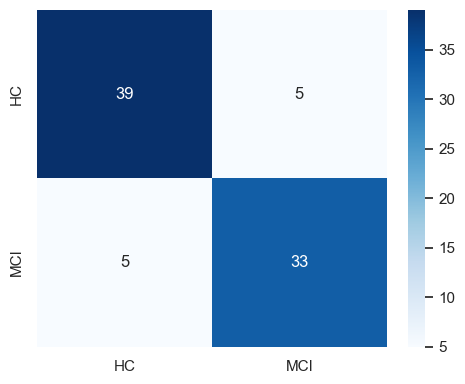

In [13]:
# Prepare Data
print(f'Available columns in Baseline: {df_baseline.columns.tolist()}')
target_col = 'Diagnosis_base'
if target_col not in df_baseline.columns:
    target_col = 'Diagnosis'

# Drop remaining leakage for guarantee
X = df_baseline.drop(columns=[target_col, 'Condition', 'Condition_clean'], errors='ignore')
y = df_baseline[target_col]

# Initialize Model
model_base = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)

# Evaluate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_base = cross_val_score(model_base, X, y, cv=cv, scoring='accuracy')
print(f"Baseline Accuracy: {scores_base.mean():.4f}")

# Confusion Matrix
y_pred_base = cross_val_predict(model_base, X, y, cv=cv)
fig = plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y, y_pred_base), annot=True, fmt='d', cmap='Blues',
            xticklabels=['HC', 'MCI'], yticklabels=['HC', 'MCI'])
print("Baseline Confusion Matrix")

out_fp = os.path.join(OUT_FIGS, "baseline_confusion_matrix.pdf")
save_and_show(fig, out_fp)

# 3. Model Selection Benchmark for Longitudinal Model

Comparing algorithms (LR, RF, DT, SVM, NB, XGBoost) with feature selection (k=10) using LOOCV for necessary feature selection required models.

Running Benchmark...
Logistic Regression: 0.5319
Decision Tree: 0.4894
Random Forest: 0.3617
SVM: 0.5957
Naive Bayes: 0.3617
KNN: 0.6170
XGBoost: 0.5106
Baseline Model Benchmark Results (LOOCV)


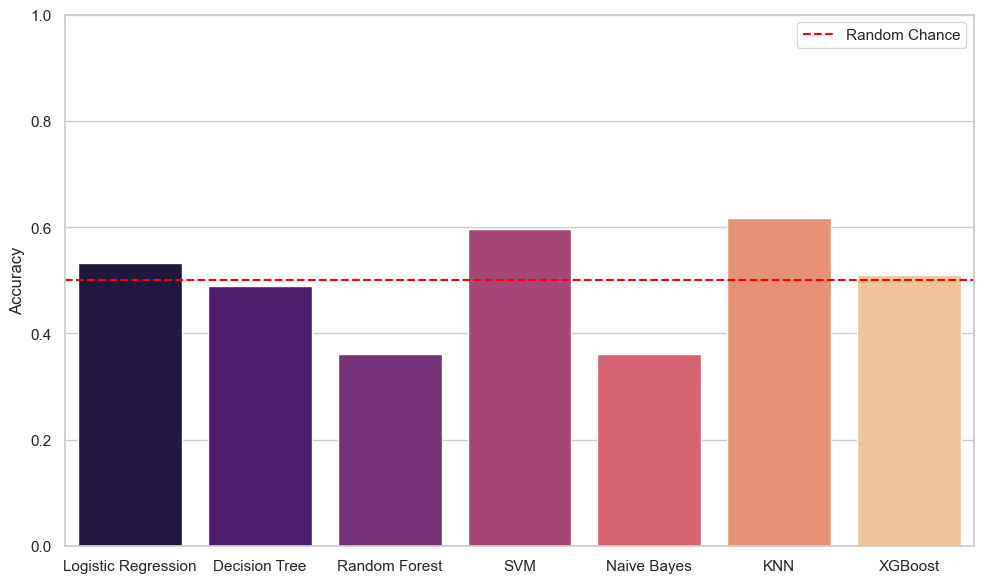

In [14]:
# Prepare Longitudinal Data
target_long = 'MCI_progression_V1' if 'MCI_progression_V1' in df_longitudinal.columns else 'MCI_progression'
df_long_model = df_longitudinal.dropna(subset=[target_long]).copy()
# Create binary target (-1 -> 0 (decrease/regression), 1 -> 1(Progression))
df_long_model['target_binary'] = df_long_model[target_long].apply(lambda x: 0 if x < 0 else 1)
y_long = df_long_model['target_binary']

# Drop remaining leakage
leakage_keywords = ['_V2', '_Diff', 'progression', 'target', 'Diagnosis_V2', 'MCI_score_V2', 'diff']
features_to_drop = [c for c in df_long_model.columns if any(k.lower() in c.lower() for k in leakage_keywords)]
X_long = df_long_model.drop(columns=features_to_drop, errors='ignore')

# Identify and discard columns with variance 0 (all values ​​are the same)
# Capture feature names before VarianceThreshold
feature_names = X_long.columns
selector = VarianceThreshold(threshold=0) 
X_long = selector.fit_transform(X_long)
# Update feature names after VarianceThreshold
feature_names = feature_names[selector.get_support()]

# Define Models (No Scaler needed as data is pre-scaled)
# Model List (for benchmark testing)
models_longitudinal = {
    'Logistic Regression': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
    ]),

    'Decision Tree': Pipeline([
        ('clf', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42))
    ]),

    'Random Forest': Pipeline([
        ('clf', RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42))
    ]),

    'SVM': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', SVC(kernel='linear', class_weight='balanced', random_state=42))
    ]),

    'Naive Bayes': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', GaussianNB())
    ]),

    'KNN': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),

    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        random_state=42
    )
}

cv_loo = LeaveOneOut()
results_long = {}

print("Running Benchmark...")
for name, model in models_longitudinal.items():
    acc = cross_val_score(model, X_long, y_long, cv=cv_loo, scoring='accuracy').mean()
    results_long[name] = acc
    print(f"{name}: {acc:.4f}")

# Plot Benchmark
fig = plt.figure(figsize=(10, 6))
x_data = list(results_long.keys())
y_data = list(results_long.values())
sns.barplot(x=x_data, y=y_data, hue=x_data, legend=False, palette='magma')
print("Baseline Model Benchmark Results (LOOCV)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.axhline(0.5, color='red', linestyle='--', label='Random Chance')
plt.legend()

outfp = os.path.join(OUT_FIGS, 'longitudinal_benchmark.pdf')
save_and_show(fig, outfp)

# 4. Final Longitudinal Model for Prognosis (KNN)

Training the best performing model (KNN) for detailed evaluation.

Longitudinal Accuracy (LOOCV): 0.6170
Longitudinal Confusion Matrix (LOOCV)


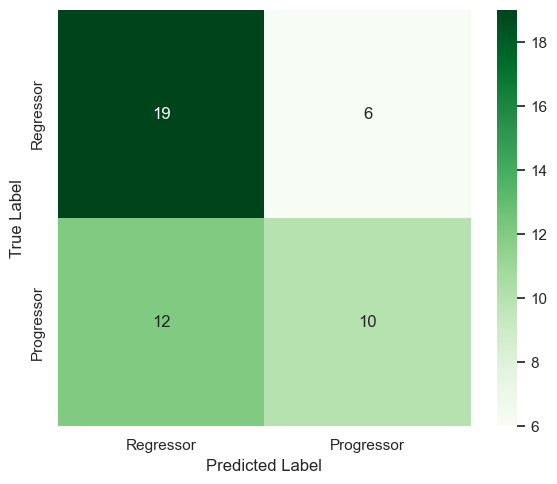


Top 10 Selected Features:
['CVT_N1minLoc_C4_V1', 'CVT_N1minLoc_Fz_V1', 'CVT_P100300maxPeak_O2_V1', 'CVT_P100300maxPeak_P4_V1', 'CVT_P100300maxPeak_T3_V1', 'CVT_P150300avg_P4_V1', 'CVT_P150300avg_T6_V1', 'CVT_SNR_P3_V1', 'SIR_P200maxLoc_T6_V1', 'SIR_SNR_T3_V1']


In [15]:
# Pipeline: SelectKBest -> KNN
pipeline = Pipeline([
    ('selector', SelectKBest(score_func=f_classif, k=10)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

cv_loo = LeaveOneOut()
scores_long = cross_val_score(pipeline, X_long, y_long, cv=cv_loo, scoring='accuracy')
print(f"Longitudinal Accuracy (LOOCV): {scores_long.mean():.4f}")

# Confusion Matrix
y_pred_long = cross_val_predict(pipeline, X_long, y_long, cv=cv_loo)
fig = plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_long, y_pred_long), annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Regressor', 'Progressor'], yticklabels=['Regressor', 'Progressor'])
print("Longitudinal Confusion Matrix (LOOCV)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

outfp = os.path.join(OUT_FIGS, 'longitudinal_confusion_matrix.pdf')
save_and_show(fig, outfp)

# Identify Selected Features
pipeline.fit(X_long, y_long)
selected_mask = pipeline.named_steps['selector'].get_support()
selected_features = feature_names[selected_mask]
print(f"\nTop 10 Selected Features:\n{selected_features.tolist()}")

# 4. XAI: Explainable AI for KNN

Visualizing Feature Importance (SelectKBest Scores) and Decision Boundary (KNN).


## 4.1. Feature Importance (SelectKBest Scores)

Feature Importance (SelectKBest F-Scores)


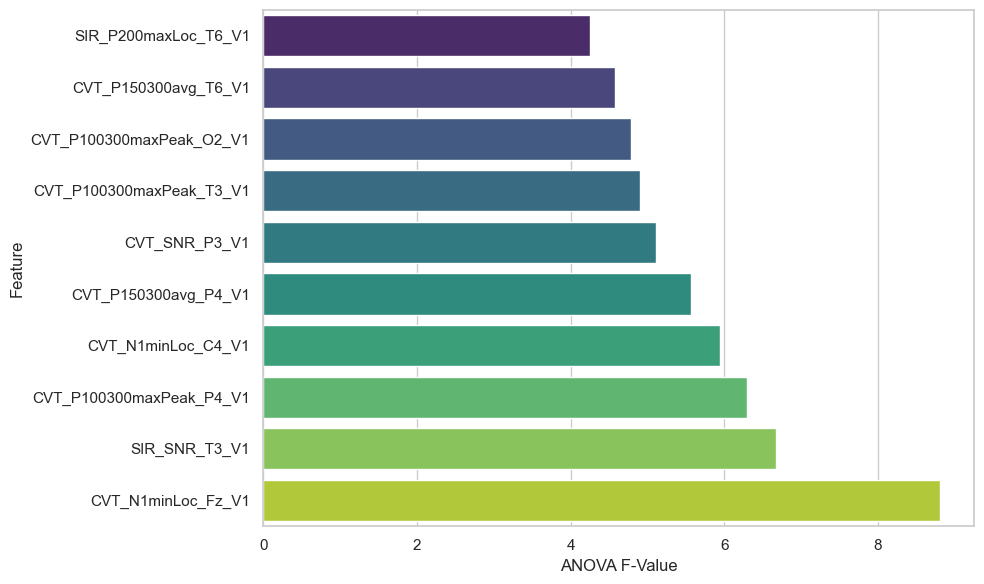

In [16]:
# 4.1. Feature Importance (SelectKBest Scores)
# KNN does not provide coefficients, so we use the ANOVA F-values from SelectKBest
selector = pipeline.named_steps['selector']
scores = selector.scores_[selected_mask]

feat_imp = pd.DataFrame({'Feature': selected_features, 'Score': scores})
feat_imp = feat_imp.sort_values(by='Score', ascending=True)

fig = plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Score', y='Feature', hue='Feature', legend=False, palette='viridis')
print("Feature Importance (SelectKBest F-Scores)")
plt.xlabel("ANOVA F-Value")
plt.ylabel("Feature")

outfp = os.path.join(OUT_FIGS, 'feature_importance.pdf')
save_and_show(fig, outfp)

## 4.2  t-SNE Visualization

Running t-SNE on top 10 features...
t-SNE Visualization of KNN Feature Space
(Local Neighborhoods of Selected Features)


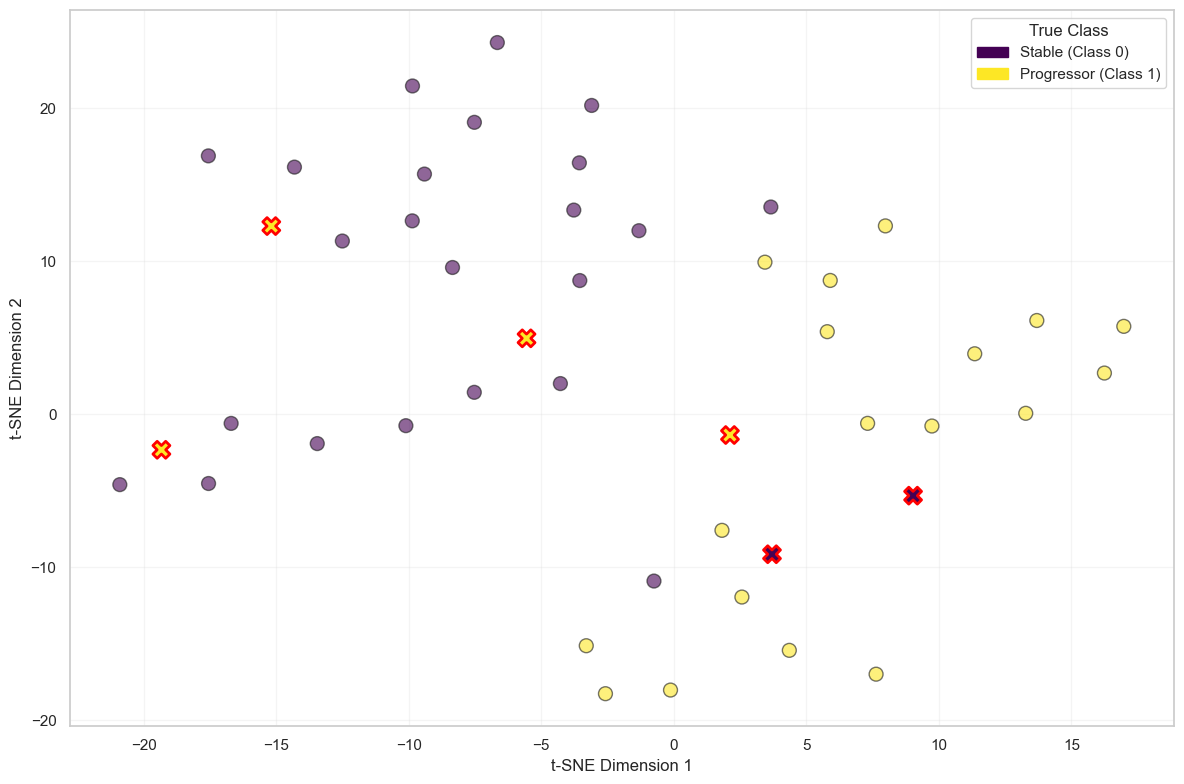

In [17]:
# Explanation: KNN relies on local neighborhoods. 
# t-SNE is non-linear and preserves local structure, making it ideal for 
# visualizing the feature space of distance-based models like KNN.

# Transform data using the pipeline's selector (focus only on top k features)
# We use the raw values (or scaled values if scaler is in pipeline) of the selected features.
X_selected_for_tsne = pipeline.named_steps['selector'].transform(X_long)

print(f"Running t-SNE on top {X_selected_for_tsne.shape[1]} features...")

# Initialize t-SNE
# perplexity=10 is usually good for smaller datasets; it controls the neighborhood size.
tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_selected_for_tsne)

# Get model predictions to highlight misclassified points
y_pred_tsne = pipeline.predict(X_long)
correct_mask = (y_long == y_pred_tsne)

# Plotting
fig = plt.figure(figsize=(12, 8))

# Plot Correct Predictions (Circles)
plt.scatter(X_tsne[correct_mask, 0], X_tsne[correct_mask, 1], 
            c=y_long[correct_mask], cmap='viridis', 
            marker='o', s=100, alpha=0.6, edgecolors='k', label='Correct Prediction')

# Plot Misclassifications (X shape) - This adds XAI value by showing "hard" samples
plt.scatter(X_tsne[~correct_mask, 0], X_tsne[~correct_mask, 1], 
            c=y_long[~correct_mask], cmap='viridis', 
            marker='X', s=150, linewidths=2, edgecolors='red', label='Misclassified')

print("t-SNE Visualization of KNN Feature Space\n(Local Neighborhoods of Selected Features)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Custom Legend for Classes
class_0 = mpatches.Patch(color=plt.cm.viridis(0.0), label='Stable (Class 0)')
class_1 = mpatches.Patch(color=plt.cm.viridis(1.0), label='Progressor (Class 1)')
plt.legend(handles=[class_0, class_1], loc='best', title="True Class")
plt.grid(True, alpha=0.2)

outfp = os.path.join(OUT_FIGS, 'tsne_knn.pdf')
save_and_show(fig, outfp)

## 4.3. Parallel Coordinates Plot (Multidimensional Value Analysis)

In [18]:
# Helper function to convert numpy array to DataFrame if needed
if not isinstance(X_long, pd.DataFrame):
    X_temp = df_long_model.drop(columns=features_to_drop, errors='ignore')
    selector_var = VarianceThreshold(threshold=0)
    X_values = selector_var.fit_transform(X_temp)
    valid_cols = X_temp.columns[selector_var.get_support()]
    X_long = pd.DataFrame(X_values, columns=valid_cols)
    
    print(f"Fixed, New X_long dimension: {X_long.shape} and now has column names.")
else:
    print("X_long is already a DataFrame.")

Fixed, New X_long dimension: (47, 578) and now has column names.


Parallel Coordinates Plot (Normalized Feature Values)


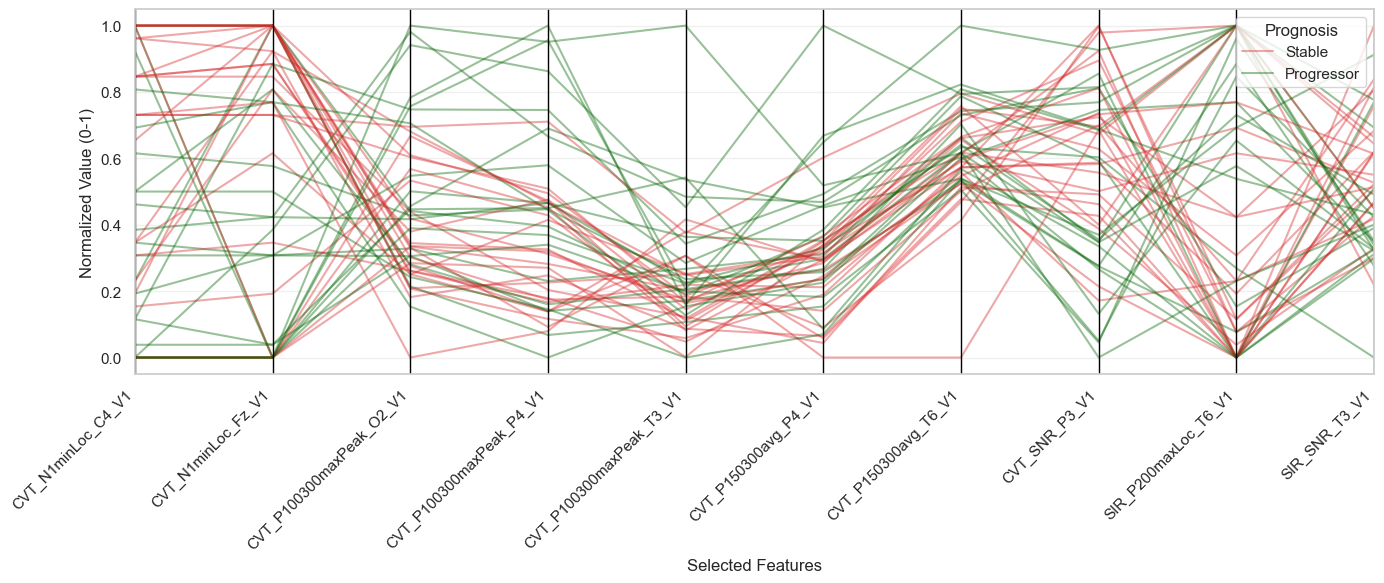

In [19]:
# Explanation: This plot visualizes the normalized values of the selected 
# features across the two classes. It helps identify specific value ranges 
# or thresholds where 'Stable' and 'Progressor' patients diverge.

# Identify Selected Features
mask = pipeline.named_steps['selector'].get_support()
selected_cols = X_long.columns[mask].tolist()

# Create a temporary DataFrame for visualization
df_vis = X_long[selected_cols].copy()

# Normalize features to 0-1 range (Crucial for Parallel Coordinates)
# Without normalization, features with large scales (e.g., Power) would dominate the plot.
df_vis = (df_vis - df_vis.min()) / (df_vis.max() - df_vis.min())

# Add the Target column for coloring
df_vis['Progression_Status'] = y_long.map({0: 'Stable', 1: 'Progressor'})

# Plotting
fig = plt.figure(figsize=(14, 6))
parallel_coordinates(
    df_vis, 
    'Progression_Status', 
    color=('#D62728', '#006400'), # Red (Progressor) vs Dark Green (Stable)
    alpha=0.4,
    linewidth=1.5
)

print("Parallel Coordinates Plot (Normalized Feature Values)")
plt.ylabel("Normalized Value (0-1)")
plt.xlabel("Selected Features")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title="Prognosis", loc='upper right')
plt.tight_layout()

outfp = os.path.join(OUT_FIGS, 'parallel_coordinates.pdf')
save_and_show(fig, outfp)

# 5. Consistency & Expected vs Actual

Comparing model performance against expectations.

Model Performance: Expected vs Actual


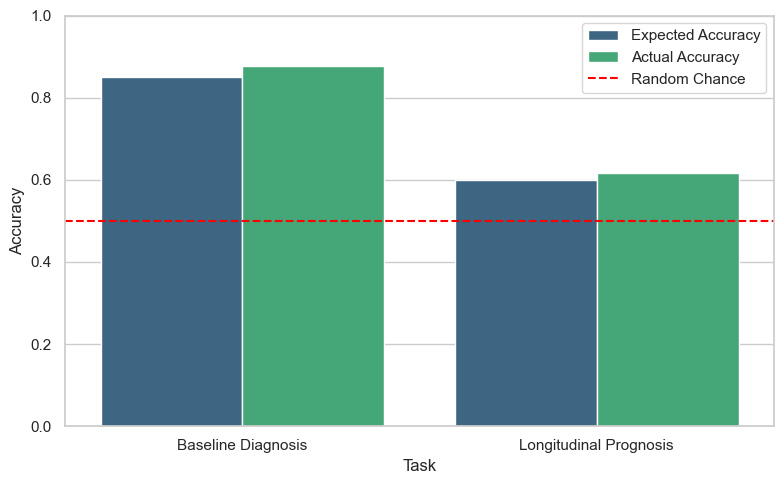

                     Task  Expected Accuracy  Actual Accuracy
0      Baseline Diagnosis               0.85         0.877941
1  Longitudinal Prognosis               0.60         0.617021


In [20]:
# Data for Comparison
results_comp = {
    'Task': ['Baseline Diagnosis', 'Longitudinal Prognosis'],
    'Expected Accuracy': [0.85, 0.60],
    'Actual Accuracy': [scores_base.mean(), scores_long.mean()]
}
df_res = pd.DataFrame(results_comp)

# Plot
fig = plt.figure(figsize=(8, 5))
df_melt = df_res.melt(id_vars='Task', var_name='Type', value_name='Accuracy')
sns.barplot(data=df_melt, x='Task', y='Accuracy', hue='Type', palette='viridis')
plt.ylim(0, 1.0)
plt.axhline(0.5, color='red', linestyle='--', label='Random Chance')
print("Model Performance: Expected vs Actual")
plt.legend()
outfp = os.path.join(OUT_FIGS, 'model_performance.pdf')
save_and_show(fig, outfp)

print(df_res)